In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import os 
import glob

In [2]:
# Defining classes for the dataframes
class AmenityPoint:
    def __init__(self, geometry, lat, lon, amenity, name, addr_city):
        self.geometry = geometry
        self.lat = lat
        self.lon = lon
        self.amenity = amenity
        self.name = name
        self.addr_city = addr_city

class AmenityPolygon:
    def __init__(self, geometry, lat, lon, amenity, name, addr_city):
        self.geometry = geometry
        self.lat = lat
        self.lon = lon
        self.amenity = amenity
        self.name = name
        self.addr_city = addr_city

In [4]:
# Read the building footprints data

buildingfootprints_gdf = gpd.read_file('manila_building_footprints.geojson')

buildingfootprints_gdf.head()

,id,geometry
0,0,"POLYGON ((120.95954 14.62190, 120.95945 14.621..."
1,1,"POLYGON ((120.96084 14.62342, 120.96095 14.623..."
2,2,"POLYGON ((120.96181 14.60838, 120.96172 14.608..."
3,3,"POLYGON ((120.96087 14.62855, 120.96103 14.628..."
4,4,"POLYGON ((120.96158 14.62105, 120.96162 14.621..."


In [2]:
# Load the Manila amenities data into a Geopandas dataframe
from shapely import wkt

manila_amenities_df = pd.read_csv('manila_amenities.csv')
manila_amenities_df['geometry'] = manila_amenities_df['geometry'].apply(wkt.loads)
manila_amenities_gdf = gpd.GeoDataFrame(manila_amenities_df, crs='epsg:4326')

# Separate into point and polygon dataframes
manila_amenities_polygon_gdf = manila_amenities_gdf[manila_amenities_gdf['geometry'].geom_type == 'Polygon']
manila_amenities_point_gdf = manila_amenities_gdf[manila_amenities_gdf['geometry'].geom_type == 'Point']

# Add a column to the polygon dataframe to store a list of Amenity Points within the polygon
manila_amenities_polygon_gdf['amenity_points'] = None

c:\Users\jmcvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [3]:
manila_amenities_gdf['amenity'].unique()

array(['education', 'finance', 'government offices', 'grocery', nan,
       'public_market', 'health', 'malls', 'residential areas',
       'security', 'transportation'], dtype=object)

In [5]:
if manila_amenities_polygon_gdf.loc[manila_amenities_polygon_gdf['name'] == 'EGI Taft Tower']['geometry'].intersects(manila_amenities_point_gdf.loc[manila_amenities_point_gdf['name'] == 'Oraldent Dental Center']['geometry']):
    print("Okay")
else:
    print("Not okay")

C:\Users\jmcvi\AppData\Local\Temp\ipykernel_1224\2980626855.py:1: UserWarning: The indices of the two GeoSeries are different.
  if manila_amenities_polygon_gdf.loc[manila_amenities_polygon_gdf['name'] == 'EGI Taft Tower']['geometry'].intersects(manila_amenities_point_gdf.loc[manila_amenities_point_gdf['name'] == 'Oraldent Dental Center']['geometry']):


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [12]:
# For each polygon in the polygon dataframe, find all the points from the point dataframe lying inside that polygon
# Store the list of points in the 'amenity_points' column of the polygon dataframe as a list of points
for index, polygon in manila_amenities_polygon_gdf.iterrows():
    points_within_polygon = []
    #temp_polygon_gdf = gpd.GeoDataFrame([{'geometry': polygon['geometry']}])
    for point_index, point in manila_amenities_point_gdf.iterrows():
        try:
            #temp_point_gdf = gpd.GeoDataFrame([{'geometry': point['geometry']}])
            #if temp_point_gdf.geometry.intersects(temp_polygon_gdf.geometry.iloc[0]):
            if polygon['geometry'].intersects(point['geometry']):
                newPoint = AmenityPoint(point['geometry'], point['geometry'].y, point['geometry'].x, point['amenity'], point['name'], point['addr_city'])
                points_within_polygon.append(point)
        except Exception as e:
            print(f"Error processing polygon {index} point {point_index}: {e}")
    manila_amenities_polygon_gdf.at[index, 'amenity_points'] = points_within_polygon

Error processing polygon 2992 point 240: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 241: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 242: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 243: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 244: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 245: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 246: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 247: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 248: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 249: 'NoneType' object has no attribute 'intersects'
Error processing polygon 2992 point 250: 'NoneType' object has no attribute 'intersects'
Error processing poly

In [13]:
manila_amenities_polygon_gdf.to_csv('manila_amenities_polygon.csv')

In [15]:
manila_amenities_point_gdf.head()

,amenity,addr_city,name,x,y,geometry
434,malls,Manila,Tutuban Centermall 1,120.972862,14.607510,POINT (120.97286 14.60751)
435,malls,Manila,NaN,120.982471,14.603893,POINT (120.98247 14.60389)
436,malls,Manila,Carriedo Arcade,120.982849,14.598686,POINT (120.98285 14.59869)
437,malls,Manila,Isetann Cinerama Recto,120.984273,14.602998,POINT (120.98427 14.60300)
438,malls,Manila,Lucky Chinatown Parking Exit,120.972931,14.602751,POINT (120.97293 14.60275)


In [13]:
# Save the dataframes to a file
manila_amenities_polygon_gdf.to_csv('manila_amenities_polygon.csv')

C:\Users\jmcvi\AppData\Local\Temp\ipykernel_12324\1156095006.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


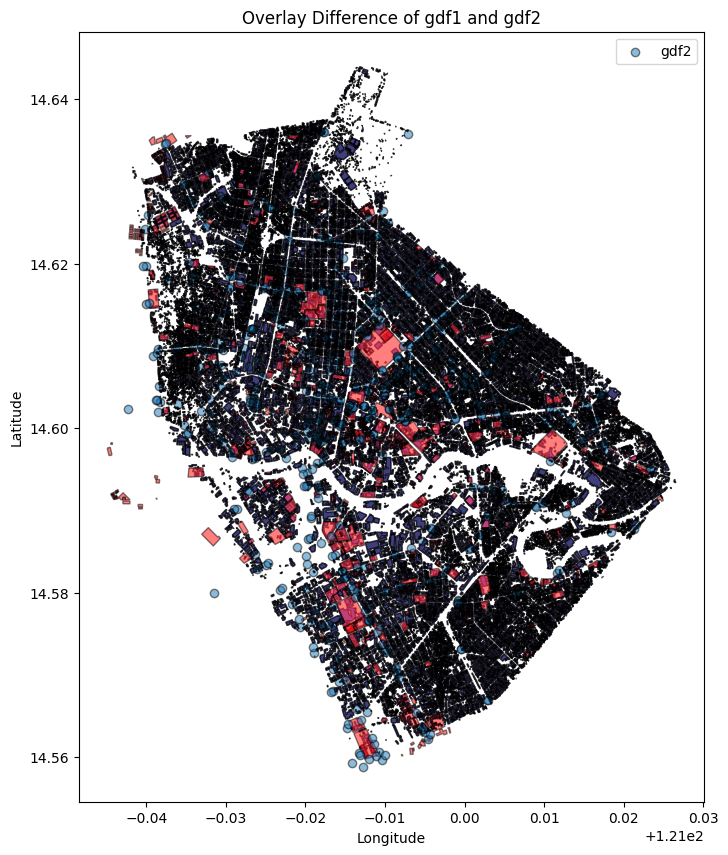

In [19]:
manila_amenities_polygon_gdf = manila_amenities_gdf[manila_amenities_gdf['geometry'].geom_type == 'Polygon']
polygon_diff = gpd.overlay(buildingfootprints_gdf, manila_amenities_polygon_gdf, how='difference')

fig, ax = plt.subplots(figsize=(10, 10))
buildingfootprints_gdf.plot(ax=ax, facecolor='blue', edgecolor='black', alpha=0.5, label='Building Footprints')
manila_amenities_gdf.plot(ax=ax, facecolor='red', edgecolor='black', alpha=0.5, label='Amenities')
polygon_diff.plot(ax=ax, facecolor='black', edgecolor='black', alpha=0.5, label='Difference')
ax.legend()
plt.title('Overlay Difference of Building Footprints and Manila Amenities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


C:\Users\jmcvi\AppData\Local\Temp\ipykernel_12324\3106236790.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


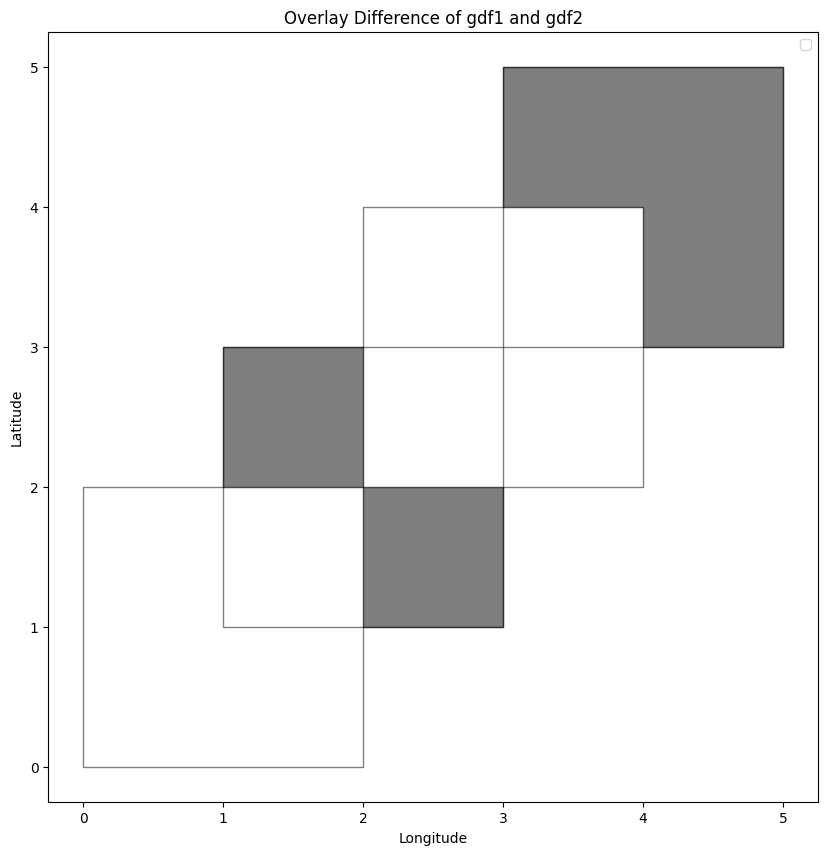

In [21]:
# Illustrative example of using gpd.overlay

from shapely.geometry import Polygon

polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),

                              Polygon([(2,2), (4,2), (4,4), (2,4)])])

polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),

                              Polygon([(3,3), (5,3), (5,5), (3,5)])])

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1_data':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2_data':[1,2]})

diff = gpd.overlay(df2, df1, how='difference')['geometry']

fig, ax = plt.subplots(figsize=(10, 10))
df1.plot(ax=ax, facecolor='white', edgecolor='black', alpha=0.5, label='gdf1')
df2.plot(ax=ax, facecolor='white', edgecolor='black', alpha=0.5, label='gdf2')
diff.plot(ax=ax, facecolor='black', edgecolor='black', alpha=0.5, label='Difference')
ax.legend()
plt.title('Overlay Difference of gdf1 and gdf2')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()